# Entorno

In [1]:
import torch
import torchaudio
import numpy as np
import torch.nn as nn
from random import randint
import pytorch_lightning as pl
from pydub import AudioSegment
from scripts.extract import load_heart_noised_paths
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
from scripts.plot import plot_audio_sample, plot_prediction_from_tuple
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

# Relación de datos

In [2]:
heart_noised = load_heart_noised_paths(
    clean_dir="data/heart_sound",
    noised_dir="data/heart_noised",
)

heart_noised[:3]

[('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_454noise_-17dB_louder.wav'),
 ('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_550noise_-14dB_louder.wav'),
 ('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_106noise_-14dB_louder.wav')]

# Cómo suena?

In [3]:
test = heart_noised[randint(0, len(heart_noised))]

audio_clean = AudioSegment.from_file(test[0])
audio_noisy = AudioSegment.from_file(test[1])

In [4]:
audio_clean

In [5]:
audio_noisy

# Cómo se ve?

In [6]:
clean_array = np.array(audio_clean.get_array_of_samples())
noisy_array = np.array(audio_noisy.get_array_of_samples())
clean_array.shape, noisy_array.shape

((58172,), (58172,))

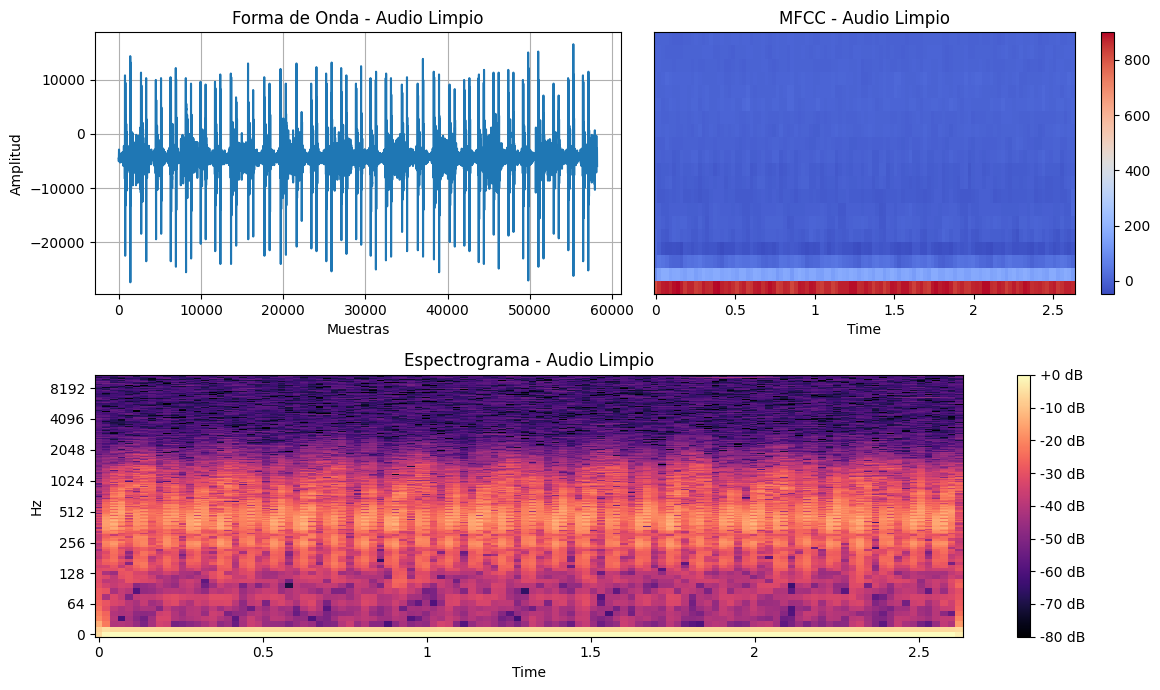

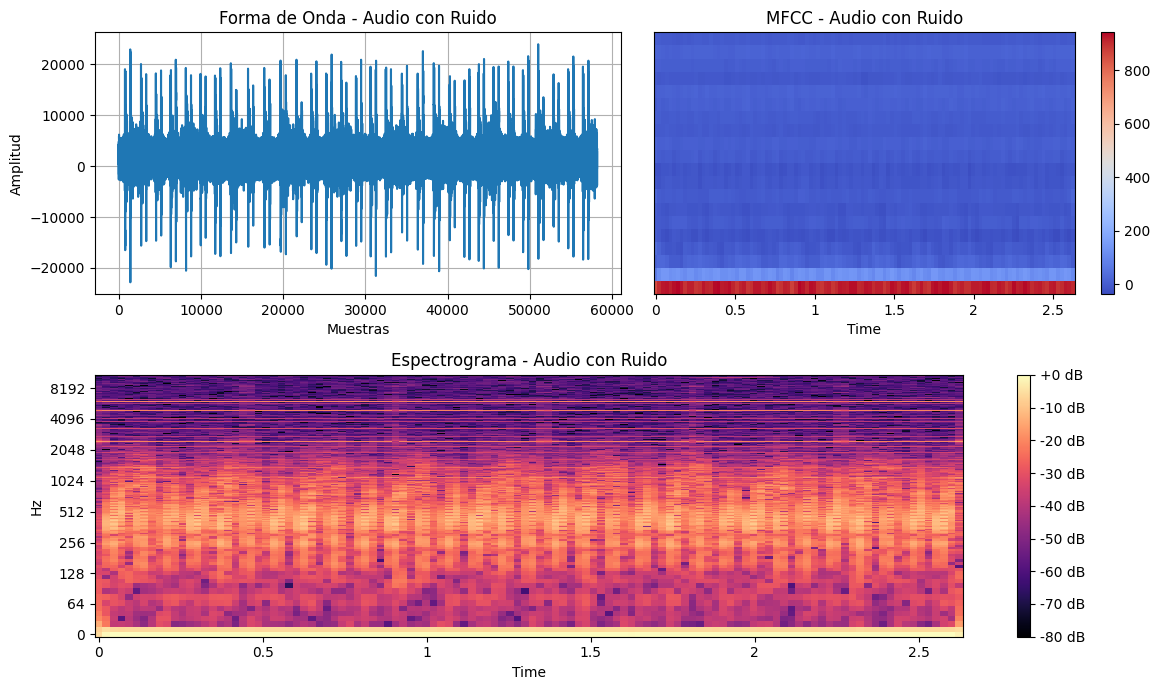

In [7]:
plot_audio_sample(clean_array, "Audio Limpio")
plot_audio_sample(noisy_array, "Audio con Ruido")

# CustomDataset class

In [8]:
class CoraDenoiserDataset(Dataset):
    def __init__(self, data_tuples, transform=None, duration=None):
        self.data_tuples = data_tuples
        self.transform = transform
        if duration is None:
            self.min_duration = self.calculate_min_duration(level=10)
        else:
            self.min_duration = duration

    def __len__(self):
        return len(self.data_tuples)

    def calculate_min_duration(self, level: int = 1):
        self.durations = []
        for _, audio_path in self.data_tuples:
            audio, _ = torchaudio.load(audio_path)
            self.durations.append(audio.shape[-1])

        min_dur = min(self.durations) // level
        return min_dur * level

    def adjust_audio_duration(self, audio, duration):
        if audio.shape[-1] > duration:
            audio = audio[..., :duration]
        return audio

    def normalize_audio(self, audio):
        normalized = (audio - audio.mean()) / audio.std()
        return normalized
    
    def preprocess_audio(self, idx, is_clean):
        subidx = 0 if is_clean else 1
        audio_path = self.data_tuples[idx][subidx]
        audio, sample_rate = torchaudio.load(audio_path)
        audio = self.adjust_audio_duration(audio, self.min_duration)
        audio = self.normalize_audio(audio)
        audio = audio.view(1, 1, -1)
        return audio, sample_rate

    def __getitem__(self, idx):
        clean_audio, sample_rate = self.preprocess_audio(idx, is_clean=True)
        noisy_audio, _ = self.preprocess_audio(idx, is_clean=False)

        if self.transform:
            clean_audio = self.transform(clean_audio, sample_rate)
            noisy_audio = self.transform(noisy_audio, sample_rate)

        return clean_audio.to(torch.float16), noisy_audio.to(torch.float16)

In [9]:
from scripts.transform import spec_n_mfcc

denoiser_dataset = CoraDenoiserDataset(
    data_tuples=heart_noised,
    transform=spec_n_mfcc,
    duration=100
)
# denoiser_dataset = CoraDenoiserDataset(heart_noised)

print('Data: ', len(denoiser_dataset))
print('Min audio duration: ', denoiser_dataset.min_duration)
denoiser_dataset[5][0].shape, denoiser_dataset[5][1].shape

Data:  41396
Min audio duration:  500


/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=500
  warnings.warn(


(torch.Size([1, 1, 1034]), torch.Size([1, 1, 1034]))

# Arquitectura

In [10]:
class DownConvBlock(pl.LightningModule):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, norm=True, dropout=0.0
    ):
        super(DownConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1)
        )
        if norm:
            self.layers.add_module("norm", nn.InstanceNorm2d(out_channels))

        self.layers.add_module("activation", nn.LeakyReLU(0.2))

        if dropout:
            self.layers.add_module("dropout", nn.Dropout(dropout))

    def forward(self, x):
        return self.layers(x)


class UpConvBlock(pl.LightningModule):
    def __init__(
        self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=0.0
    ):
        super(UpConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(),
        )
        if dropout:
            self.layers.add_module("dropout", nn.Dropout(dropout))

    def forward(self, x, encod_input):
        x = self.layers(x)
        encod_input = encod_input.repeat((1, 1, x.shape[2], 1))
        output = torch.cat((x, encod_input), dim=1)
        return output


class CoraDenoiser(pl.LightningModule):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_conv1 = DownConvBlock(in_channels, 64, norm=False)
        self.down_conv2 = DownConvBlock(64, 128)
        self.down_conv3 = DownConvBlock(128, 256)
        self.down_conv4 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv5 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv6 = DownConvBlock(256, 256, dropout=0.5)

        self.up_conv1 = UpConvBlock(256, 256, dropout=0.5)
        self.up_conv2 = UpConvBlock(512, 256, dropout=0.5)
        self.up_conv3 = UpConvBlock(512, 256, dropout=0.5)
        self.up_conv4 = UpConvBlock(512, 128, dropout=0.5)
        self.up_conv5 = UpConvBlock(256, 64)
        self.up_conv6 = UpConvBlock(512, 128)
        self.up_conv7 = UpConvBlock(256, 64)

        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_1 = nn.Conv2d(128, out_channels, kernel_size=(4, 4), padding=1)
        self.activation = nn.Tanh()

    def forward(self, x):
        enc1 = self.down_conv1(x)
        print("\nenc1", enc1.shape)
        enc2 = self.down_conv2(enc1)
        print("enc2", enc2.shape)
        enc3 = self.down_conv3(enc2)
        print("enc3", enc3.shape)
        enc4 = self.down_conv4(enc3)
        print("enc4", enc4.shape)
        enc5 = self.down_conv5(enc4)
        print("enc5", enc5.shape)
        enc6 = self.down_conv6(enc5)
        print("enc6", enc6.shape)

        dec1 = self.up_conv1(enc6, enc5)
        print("dec1", dec1.shape)
        dec2 = self.up_conv2(dec1, enc4)
        print("dec2", dec2.shape)
        dec3 = self.up_conv3(dec2, enc3)
        print("dec3", dec3.shape)
        dec4 = self.up_conv4(dec3, enc2)
        print("dec4", dec4.shape)
        dec5 = self.up_conv5(dec4, enc1)
        print("dec5", dec5.shape)

        final = self.upsample_layer(dec5)
        print("final upsample", final.shape)
        final = self.zero_pad(final)
        print("final zeropad", final.shape)
        final = self.conv_layer_1(final)
        print("final conv", final.shape)
        return final

    def training_step(self, batch, batch_idx):
        clean, noisy = batch
        # Forward pass
        decoded = self(noisy)
        # Calculamos la pérdida (error de reconstrucción)
        train_loss = nn.MSELoss()(decoded, clean)
        # Registramos la pérdida para su monitoreo
        self.log("train_loss", train_loss, on_epoch=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        clean, noisy = batch
        decoded = self(noisy)
        val_loss = nn.MSELoss()(decoded, clean)
        self.log("val_loss", val_loss, on_epoch=True)

        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = {
            "scheduler": CyclicLR(
                optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False
            ),
            "interval": "step",  # Frecuencia de ajuste del LR scheduler (en cada paso)
        }

        # optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        # scheduler = {
        #     'scheduler': ReduceLROnPlateau(optimizer, patience=3),
        #     'monitor': 'val_loss',  # Métrica para monitorear
        #     'interval': 'epoch',    # Frecuencia de ajuste del LR scheduler
        #     'frequency': 1          # Igual a interval, ya que estamos usando 'epoch'
        # }

        return [optimizer], [scheduler]

# Entrenamiento, validación y prueba

In [11]:
batch_size = 10
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(denoiser_dataset))
val_size = int(val_ratio * len(denoiser_dataset))
test_size = len(denoiser_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    denoiser_dataset, [train_size, val_size, test_size]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# Callbacks

In [12]:
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="autoencoder-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# callbacks = [checkpoint, early_stopping, lr_monitor]
callbacks = [checkpoint, lr_monitor]

# Entrenamiento

In [13]:
model = CoraDenoiser().to(torch.float16)

logger = TensorBoardLogger("logs/", name="cora_cleaner")

trainer = pl.Trainer(max_epochs=10, callbacks=callbacks, logger=logger)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name           | Type          | Params
--------------------------------------------------
0  | down_conv1     | DownConvBlock | 640   
1  | down_conv2     | DownConvBlock | 73.9 K
2  | down_conv3     | DownConvBlock | 295 K 
3  | down_conv4     | DownConvBlock | 590 K 
4  | down_conv5     | DownConvBlock | 590 K 
5  | down_conv6     | DownConvBlock | 590 K 
6  | up_conv1       | UpConvBlock   | 1.0 M 
7  | up_conv2       | UpConvBlock   | 2.1 M 
8  | up_conv3       | UpConvBlock   | 2.1 M 
9  | up_conv4       | UpConvBlock   | 1.0 M 
10 | up_conv5       | UpConvBlock   | 262 K 
11 | up_conv6       | UpConvBlock   | 1.0 M 
12 | up_conv7       | UpConvBlock   | 262 K 
13 | upsample_layer | Upsample      | 0     
14 | zero_pad       | ZeroPad2d     | 0     
15 | conv_layer_1   | Conv2d        | 2.0 K 
16 | activation     | Tanh      

Sanity Checking: 0it [00:00, ?it/s]

/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=500
  warnings.warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

: 

: 

# Predicción

In [ ]:
to_pred = denoiser_dataset[randint(0, len(denoiser_dataset))]

plot_prediction_from_tuple(
    model=model,
    clean_noisy_tuple=to_pred,
    duration=denoiser_dataset.min_duration,
)

In [ ]:
# Descomentar para revisar el Tensorboard en web
# !tensorboard --logdir=path_to_logs_directory

# Otra opción es VisualStudioCode: Ctrl+Shift+P -> Launch Tensorboard